# Installations

In [1]:
# Installations of libraries
!pip install PyPDF2
!pip install nltk
!pip install pdfminer
!pip install textblob
!pip install spacy
!pip install svgutils

!python -m spacy download en_core_web_sm
!python -m spacy download fr_core_news_md

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


2022-03-26 23:27:20.927114: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-03-26 23:27:20.933522: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2022-03-26 23:28:25.023885: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-03-26 23:28:25.023936: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



[+] Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')


# IMPORTS

In [11]:
# Imports
from textblob import TextBlob
from collections import Counter
from pathlib import Path

import spacy
from spacy import displacy
import fr_core_news_md

import pandas as pd

from wordcloud import *
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer

import svgutils.transform as st

import os
import en_core_web_sm
import glob
import io
import nltk

from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams

In [12]:
# nltk download
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jeremy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Jeremy\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\Jeremy\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Jeremy\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Jeremy\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

# Documents/PDFs/Texts to Texts

In [142]:
docu_path = "../res/"

# Path to Generated data
# Always the same
dataset_path = "../data/" 

# Dynamic due to filename
text_path = "../data/per_article_text_files/"
classification_path = "../data/per_article_classification/"
entities_path = "../data/per_article_entities_label/"
render_path = "../data/sentence_render_html/"
entities_visuals_path = "../data/per_article_top_entities_visuals/"

In [143]:
# Read only documents that ends with .pdf .docx .txt
pdf_files = glob.glob(os.path.join(docu_path, "*.pdf"))
doc_files = glob.glob(os.path.join(docu_path, "*.docx"))
txt_files = glob.glob(os.path.join(docu_path, "*.txt"))
accepted_files = []

accepted_files = [*pdf_files, *doc_files, *txt_files]

# Print Sample File
accepted_files[0]

'../res\\3M Moderna vaccines from US Government arrive from COVAX Facility.pdf'

In [144]:
# Function to generate a dictionary with a unique ascending id
def generate_dataset_dictionary(files):
    dict = {"Docu_ID": [], "File_Name": []}
    
    for idx, file in enumerate(files):
        split_file_name = file.split("\\")
        file_name = split_file_name[1]

        dict["Docu_ID"].append("1"+str(idx).zfill(4))
        # dict["Docu_ID"].append(file_name[:len(file_name[idx]) - 5]+"_00"+str(idx))
        dict["File_Name"].append(file_name)
    
    return dict
    

In [145]:
document_dict = generate_dataset_dictionary(accepted_files)

# Initial Dataframe
initial_df = pd.DataFrame(document_dict)
initial_df['Docu_ID'] = initial_df['Docu_ID'].astype('str')
initial_df[0:5]

,Docu_ID,File_Name
0,10000,3M Moderna vaccines from US Government arrive ...
1,10001,Asia Pacific health and finance ministers stre...
2,10002,Breastfeeding must continue amidst COVID-19.pdf
3,10003,Community Innovation to Support Surveillance a...
4,10004,"DOH, RITM, WHO establish subnational laborator..."


In [146]:
# Create dataset containing the file names of articles
initial_df.to_csv(dataset_path + "docu_dataset.csv", index=False, header=True)

In [147]:
# Function to convert document file to txt file with per line sentences
def pdf_to_text_sentences(pdf_file, docu_id):
    inFile = open(pdf_file, 'rb')
    resMgr = PDFResourceManager()
    retData = io.StringIO()
    TxtConverter = TextConverter(resMgr, retData,laparams = LAParams())
    interpreter = PDFPageInterpreter(resMgr, TxtConverter)

    # Process each pages
    for page in PDFPage.get_pages(inFile): 
        interpreter.process_page(page)


    # Write to text temporary file
    txt = retData.getvalue()

    # Acquire sentences
    blob = TextBlob(txt)
    sentences = []

    # Append to sentences whilest removing 'sentence(...)' on each sentences/list elements
    for s in blob.sentences:
         sentences.append(str(s).strip()),

    cleaned_sentences = []

    # Append to cleaned_sentences whilest removing new lines or '\n'
    for x in sentences:
         cleaned_sentences.append(x.replace("\n", " "))

    # Create and Open new temp text file and write cleaned sentences on a per line basis
    with open(text_path + "txt_" + docu_id + ".txt", 'w', encoding='utf-8') as f: 
         f.write('\n'.join(cleaned_sentences))
    
    inFile.close()

In [148]:
# Separate each sentences from the document
# May take some time
for idx in initial_df.index:
    pdf_to_text_sentences(docu_path + str(initial_df["File_Name"][idx]), str(initial_df["Docu_ID"][idx]))

In [149]:
# Generate temporary text files containing per line sentences of a single article
txt_files = glob.glob(os.path.join(text_path, "*.txt"))

text_dict = generate_dataset_dictionary(txt_files)

text_df = pd.DataFrame(text_dict)
text_df[0:5]

,Docu_ID,File_Name
0,10000,txt_10000.txt
1,10001,txt_10001.txt
2,10002,txt_10002.txt
3,10003,txt_10003.txt
4,10004,txt_10004.txt


In [150]:
# Write to data folder name = "text_dataset.csv"
text_df.to_csv(dataset_path + "text_dataset.csv", index=False, header=True)

# Classify Text File

In [151]:
# Open File
def open_file(file):
    # Open text file
    raw = open(file, encoding='utf-8').read()

    nlp = en_core_web_sm.load()
    nlp.max_length = 3000000
    
    raw_nlp = nlp(raw)
    
    return raw_nlp

In [152]:
# Function to determine sentence index of word/element per document when 
# creating another dataset (Can be used for data visualizations)
def split_sentences(raw_nlp):
    sentences = [x for x in raw_nlp.sents]
    sentence_index = []
    
    # Contain tokenized data and its corresponding sentence index
    for idx1 in range(len(sentences)):
        temporary_sentence = sentences[idx1]
        temporary_tokens = [x for x in temporary_sentence]
        
        for idx2, val in enumerate(temporary_tokens):
            sentence_index.append(idx1)
    
    return sentence_index

In [153]:
# Generate labels dataset (.csv dataset with 2 columns ["Word", "Label"])
def generate_labels_dataset(raw_nlp, docu_id):
    label = ([(x.text, x.label_) for x in raw_nlp.ents])
    word, label = zip(*label)
    labels_df = pd.DataFrame(zip(word, label), columns=["Word", "Label"])
    
    labels_df.to_csv(entities_path + "ent_" + docu_id + ".csv", index=False, header=True)

In [154]:
# Read from csv
text_df = pd.read_csv(dataset_path + "text_dataset.csv")
# Sample data
text_df[0:2]

,Docu_ID,File_Name
0,10000,txt_10000.txt
1,10001,txt_10001.txt


In [155]:
# For every text file, read each sentences/lines and use spacy nlp to classify each entities
for idx in text_df.index:
    raw_nlp = open_file(text_path + str(text_df["File_Name"][idx]))
    sentence_index = split_sentences(raw_nlp)
    generate_labels_dataset(raw_nlp, str(text_df["Docu_ID"][idx]))
    
    # Entity types such as pos tagging, inside-outside-beginning tags, entity types, etc...
    ent_type = ([(x, x.pos_, spacy.explain(x.tag_), x.tag_, x.ent_iob_, x.ent_type_) for x in raw_nlp])
    
    # Words and Tags list
    word, pos, e_tags, tags, iob, e_type = zip(*ent_type)
    
    classification_df = pd.DataFrame(zip(sentence_index, word, pos, e_tags, tags, iob, e_type), 
                      columns=["Sentence_Index", "Token", "Pos", "Explained_Tag", "Tag", "iob_Tag", "Entity_Type"])
    
    # Output to csv, do note that the csv file is for analyzing purposes
    # .csv Dataset with 7 columns: 
    # Sentence_Index (0,0,0,1,1,2, ...)
    # Token (Moderna, vaccines, from, US, Government, ...)
    # Pos (PROPN, ADP, SPACE. NUM, ...)
    # Explained_Tag (cardinal number, punctuation mark, noun, ...)
    # Tag (CD, ., NN, _SP, NNP, ...)
    # iob_Tag (B, O, B, I, O, O, ...)
    # Entity_Type (CARDINAL, TIME, ORG, LOC, ...)
    classification_df.to_csv(str(classification_path)  + "classification_" + 
                             str(text_df["Docu_ID"][idx]) + ".csv", index=False, header=True)

# Generate Visuals per Sentence

In [156]:
nlp = spacy.load("en_core_web_sm")

for idx in text_df.index:
    raw_nlp = open_file(text_path + str(text_df["File_Name"][idx]))
    
    counter = 0
    sentences = [x.text for x in raw_nlp.sents]
    
    # Only read lines with entities for faster classification
    for i in sentences:
        # Process single sentence
        sent = nlp(i)
        output_path = Path(render_path + 
                           initial_df["File_Name"][idx][:len(initial_df["File_Name"][idx]) - 4]  
                           + ".html")
        
        if sent.ents:
            if counter == 0:
                # Create svg and render one sentence
                svg = displacy.render(sent, jupyter=False, style='ent')
            else:
                # Render to existing svg
                svg = svg + displacy.render(sent, jupyter=False, style='ent')
            counter = counter + 1
        else:
            pass
        
        # Write to html
        output_path.open("w", encoding='utf-8').write(svg)
        # Path to html data folder = data/sentence_render_img

# Generate Top Tags Per Article

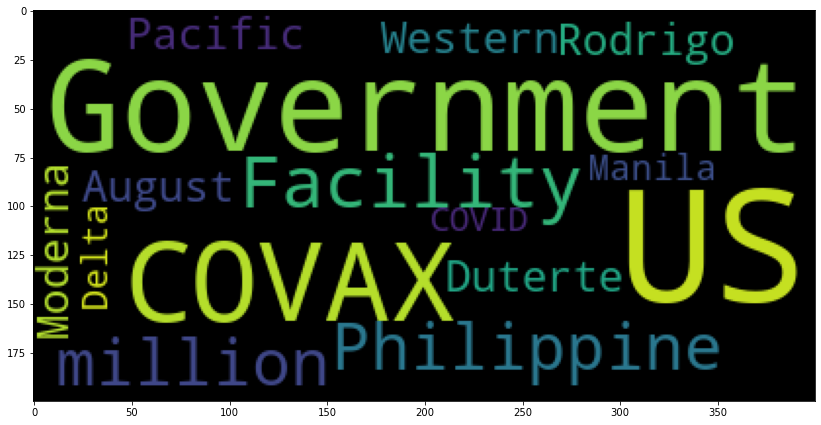

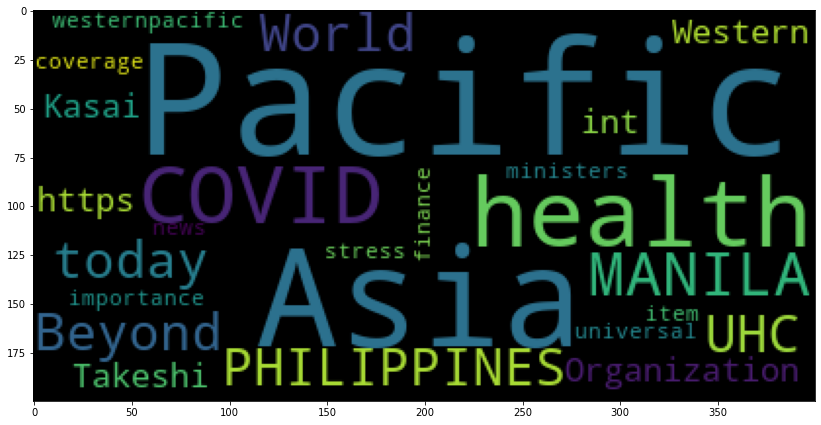

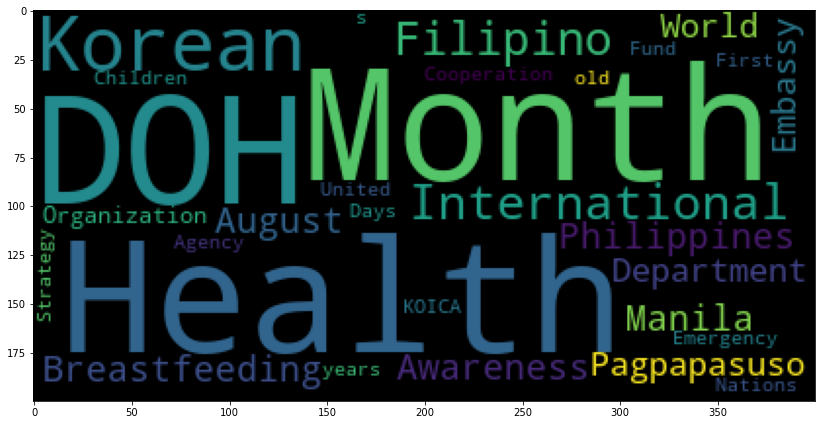

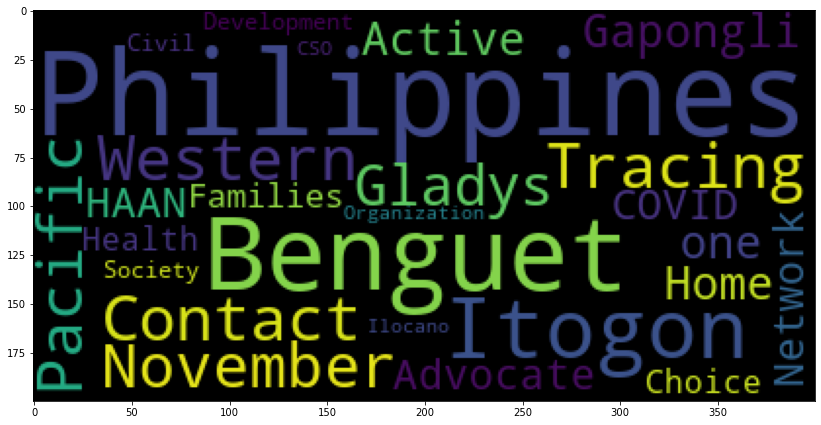

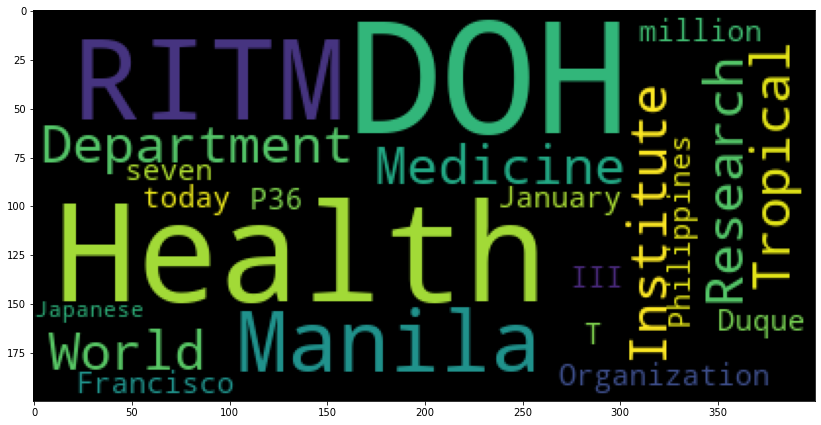

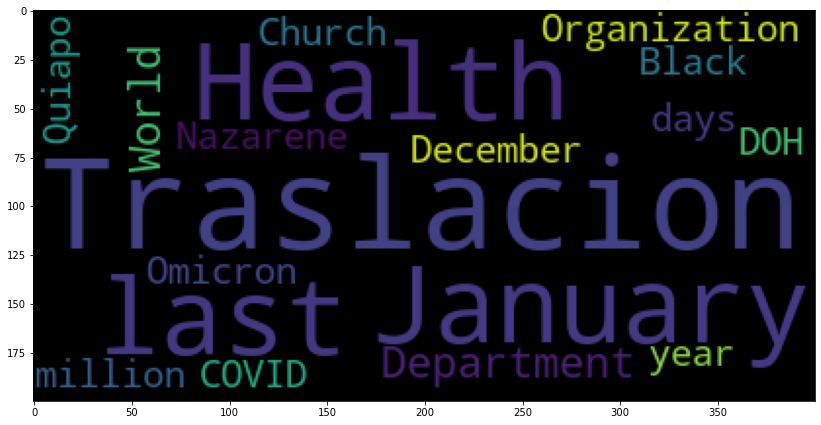

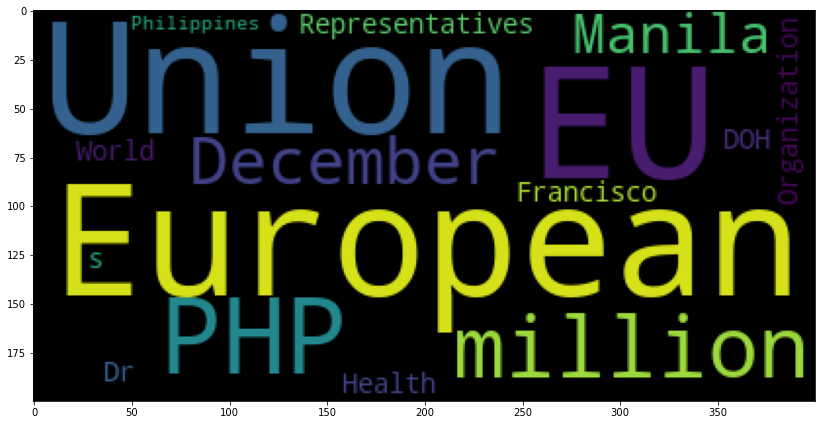

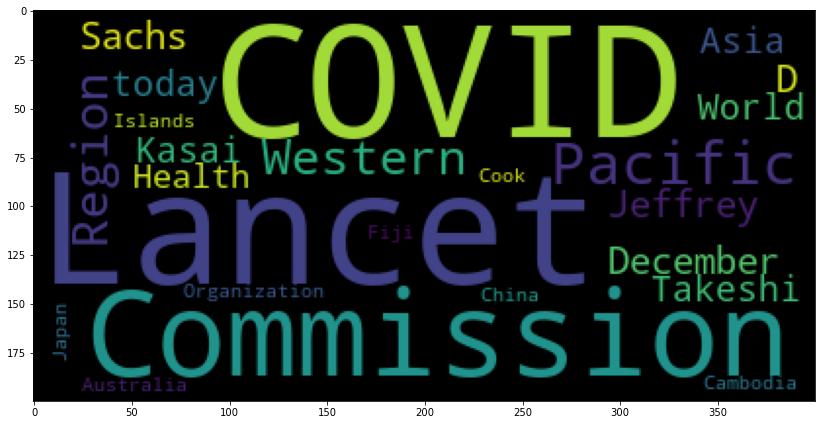

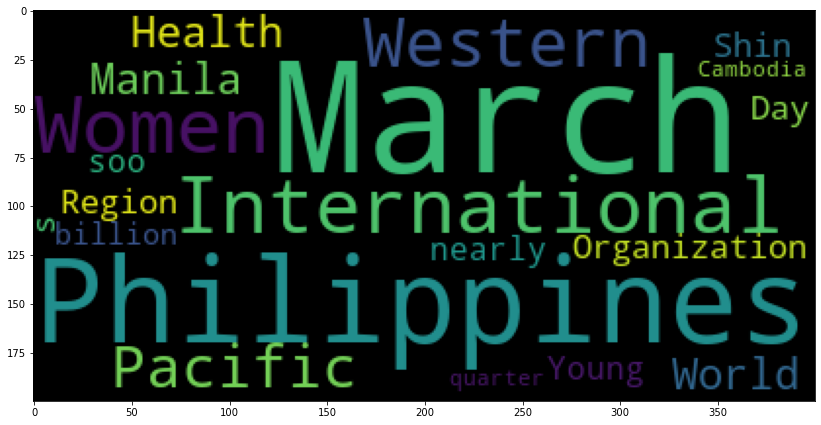

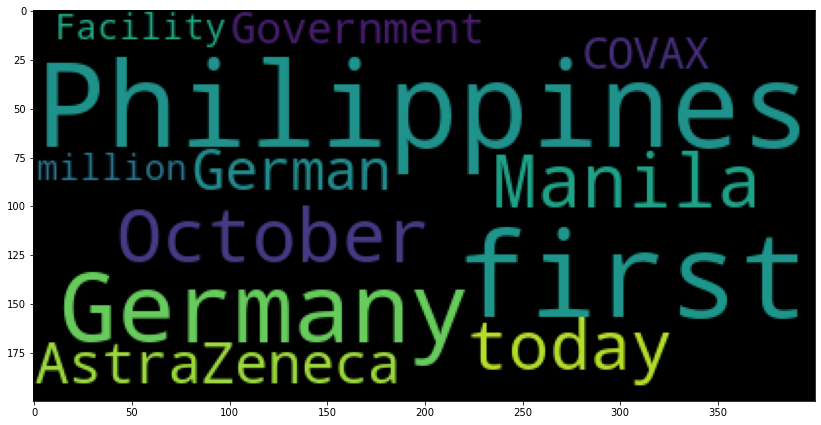

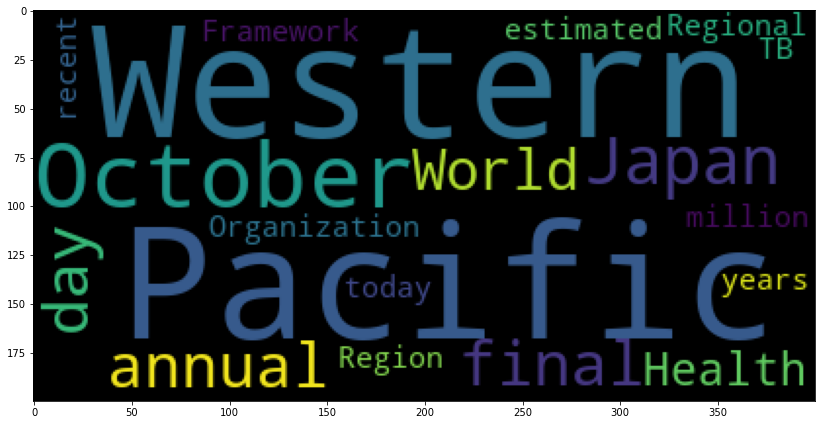

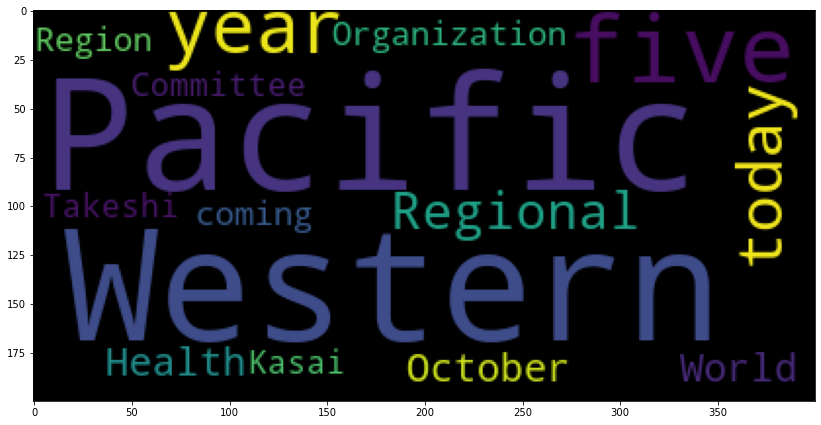

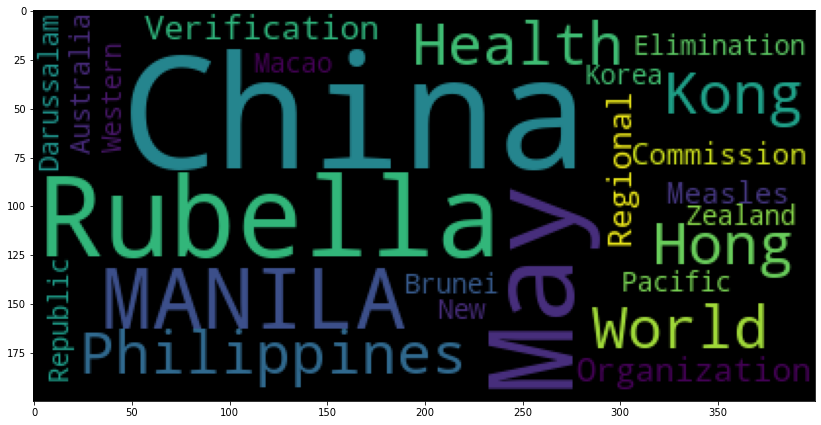

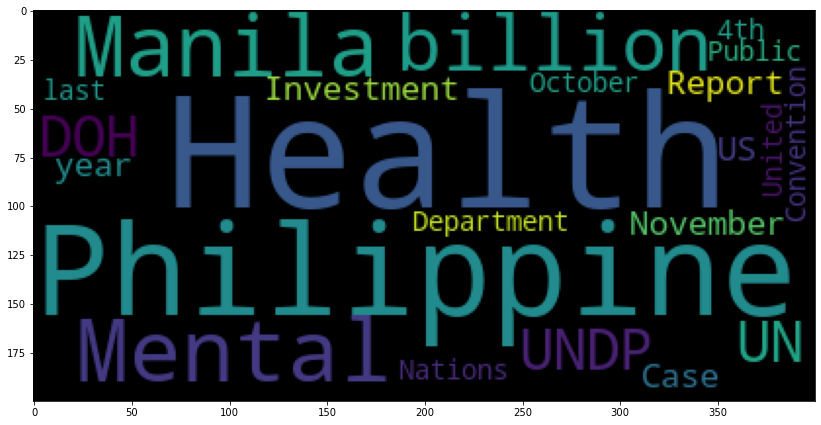

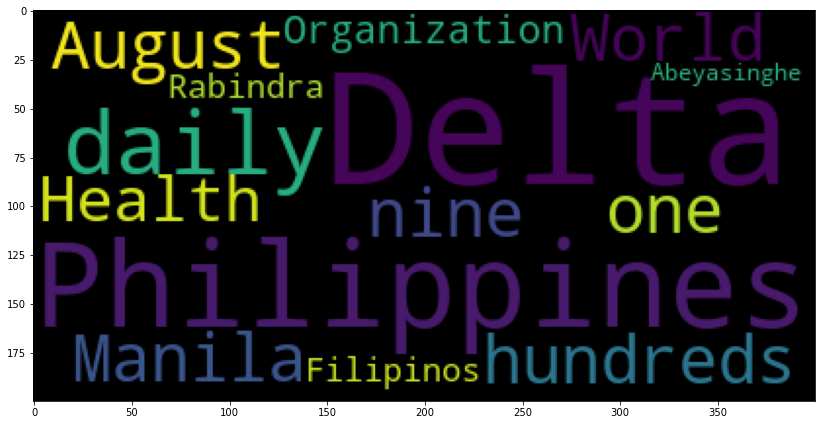

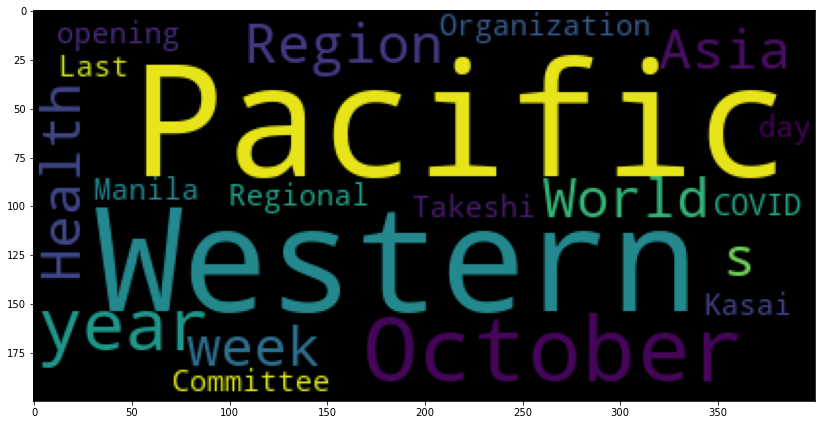

In [157]:
# Retrieve all entities csv file 
# inside the per_article_entities_label folder
ent_csv_files = glob.glob(os.path.join(entities_path, "*.csv"))

# For each csv files generate a wordcloud of the top 
for idx, ent_csv_f in enumerate(ent_csv_files):
    ent_csv_df = pd.read_csv(ent_csv_f)
    
    output_path = Path(entities_visuals_path + 
                       initial_df["File_Name"][idx][:len(initial_df["File_Name"][idx]) - 4]  
                       + ".png")

    plt.figure(figsize=(14,8))
    word_cloud = WordCloud(background_color='black',
                           max_font_size = 80).generate(" ".join(ent_csv_df['Word'][:20]))
    plt.imshow(word_cloud)
    plt.savefig(output_path)
    